In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import metrics
import csv
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


In [2]:
# datatypes
# list_of_num_muts = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,25,30,35,40,45,50,55,60]
list_of_num_muts = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,40,45,50,55,60]
model_prefixes = ['fixed_', 'sft_', 'rl_']
model_labels = {'fixed_': 'Pre-trained', 'sft_': 'SFT', 'rl_': 'PPO'}
dir_filepath = './logs/Aligning_SFT_ESM2s_wpPPO/version_12'

# Initialize dictionary to store score lists for each model prefix
score_dict = {prefix: [] for prefix in model_prefixes}

for model_prefix in model_prefixes:
    for num_muts in list_of_num_muts:
        try:
            filename = f'{model_prefix}scores_HCthreshold_HC0.9_CP0.25_{num_muts}muts.npy'
            Ensemble_of_scores = np.load(f'{dir_filepath}/{filename}')
            scores = np.median(Ensemble_of_scores, axis=0)
            # print('Number of scores:', len(scores))
            score_dict[model_prefix].append(scores)
        except:
            print(f'File not found at {dir_filepath}/{filename}')


In [3]:
# Constants
alpha = 1
predicted_wt_score = 4.1498  # predicted WT score
WT_linewidth = 2
linewidth = 1
fill = False

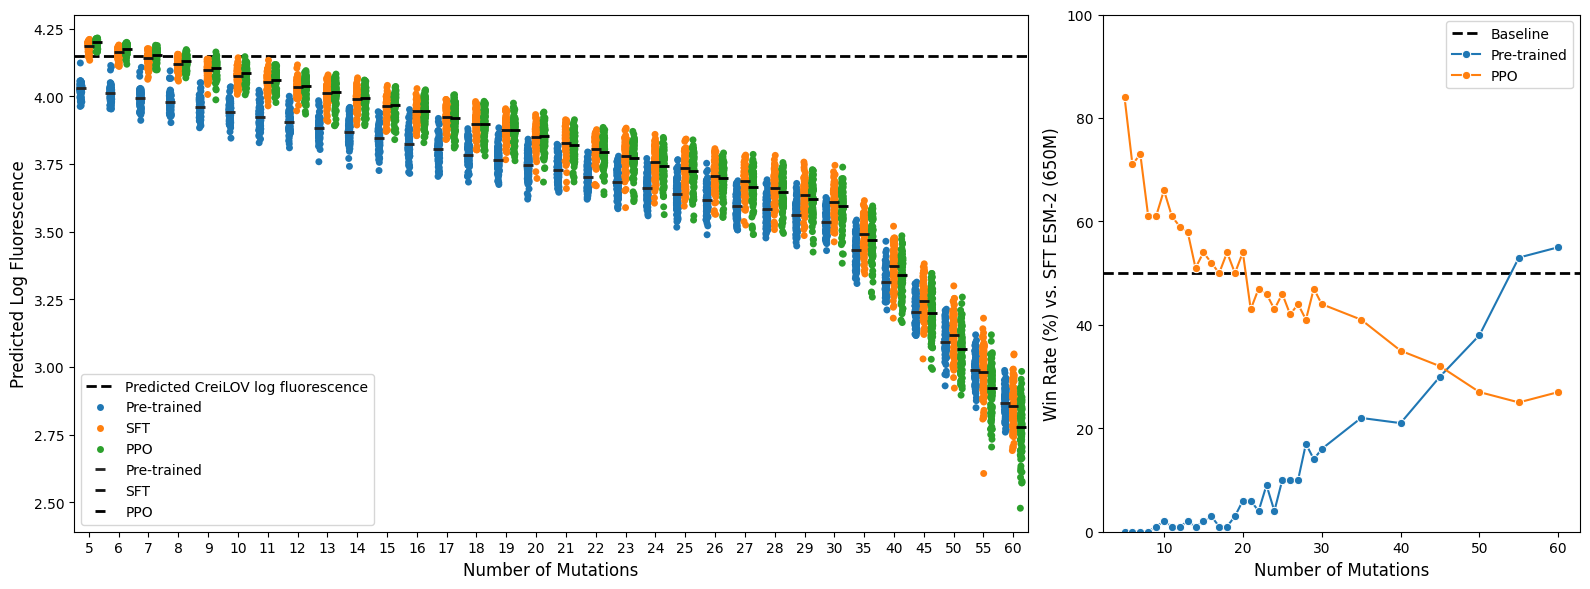

In [4]:
# Create Figure with Two Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

# --- Subplot 1: Stripplot of scores for sequences ---

# Process data for stripplot
strip_rows = []
for prefix in model_prefixes:
    label = model_labels[prefix]
    for i, num in enumerate(list_of_num_muts):
        sampled_scores = score_dict[prefix][i]
        for s in sampled_scores:
            strip_rows.append({'Number of Mutations': num, 'Predicted Log Fluorescence': s, 'Model': label})
df_strip = pd.DataFrame(strip_rows)

# Add predicted wild-type score line
ax1.axhline(predicted_wt_score, color='black', linestyle='--', linewidth=WT_linewidth, label='Predicted CreiLOV log fluorescence')

# plot scores
sns.stripplot(x='Number of Mutations', y='Predicted Log Fluorescence', hue='Model', data=df_strip, ax=ax1, jitter=True, dodge=True)
sns.pointplot(x='Number of Mutations', y='Predicted Log Fluorescence', hue='Model',
              data=df_strip, ax=ax1, estimator=np.mean, errorbar=None,
              markers='_', dodge=0.55, linestyle='none', palette='dark:black',
              zorder=10)
# Label plot
ax1.set_xlabel('Number of Mutations', fontsize=12)
ax1.set_ylabel('Predicted Log Fluorescence', fontsize=12)
ax1.legend(fontsize=10)

# --- Subplot 2: Lineplot of Win Rate vs. Mutational Regime ---

# Compute win rate relative to SFT
win_rate_rows = []
baseline = 'sft_'
for prefix in model_prefixes:
    label = model_labels[prefix]
    for i, num in enumerate(list_of_num_muts):
        if prefix == baseline:
            continue
        else:
            sft_scores = score_dict[baseline][i]
            curr_scores = score_dict[prefix][i]
            win_rate = 100 * np.mean(curr_scores > sft_scores)
        win_rate_rows.append({'Number of Mutations': num, 'WinRate': win_rate, 'Model': label})
df_win = pd.DataFrame(win_rate_rows)

# Draw the baseline as a black dashed line at 50% and capture its handle.
baseline_handle = ax2.axhline(50, color='black', linestyle='--', linewidth=WT_linewidth, label='Baseline')

# Plot lines
sns.lineplot(x='Number of Mutations', y='WinRate', hue='Model', data=df_win, marker='o', ax=ax2)

# Label plot
ax2.set_xlabel('Number of Mutations', fontsize=12)
ax2.set_ylabel('Win Rate (%) vs. SFT ESM-2 (650M)', fontsize=12)
ax2.set_ylim(0, 100)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.savefig('./figures/mutational_extrapolation.svg')
plt.savefig('./figures/mutational_extrapolation.png')
plt.show()

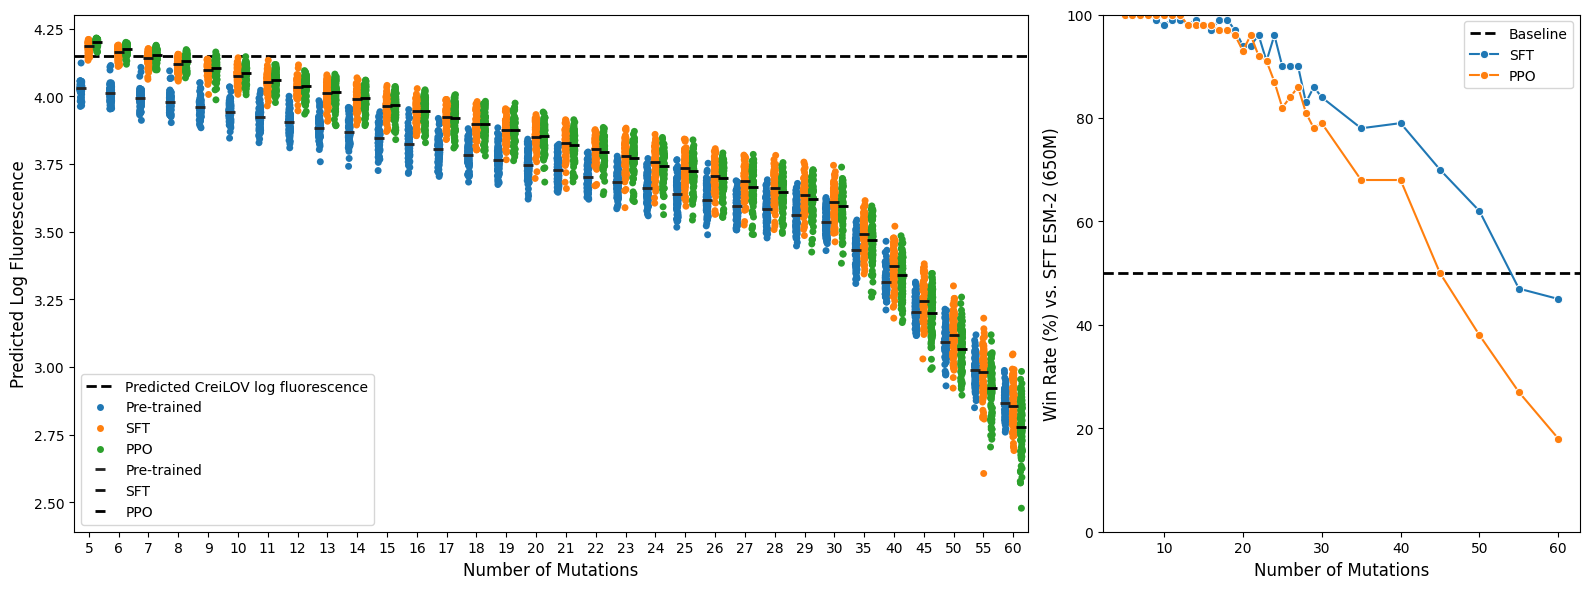

In [5]:
# Create Figure with Two Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

# --- Subplot 1: Stripplot of scores for sequences ---

# Process data for stripplot
strip_rows = []
for prefix in model_prefixes:
    label = model_labels[prefix]
    for i, num in enumerate(list_of_num_muts):
        sampled_scores = score_dict[prefix][i]
        for s in sampled_scores:
            strip_rows.append({'Number of Mutations': num, 'Predicted Log Fluorescence': s, 'Model': label})
df_strip = pd.DataFrame(strip_rows)

# Add predicted wild-type score line
ax1.axhline(predicted_wt_score, color='black', linestyle='--', linewidth=WT_linewidth, label='Predicted CreiLOV log fluorescence')

# plot scores
sns.stripplot(x='Number of Mutations', y='Predicted Log Fluorescence', hue='Model', data=df_strip, ax=ax1, jitter=True, dodge=True)
sns.pointplot(x='Number of Mutations', y='Predicted Log Fluorescence', hue='Model',
              data=df_strip, ax=ax1, estimator=np.mean, errorbar=None,
              markers='_', dodge=0.55, linestyle='none', palette='dark:black',
              zorder=10)
# Label plot
ax1.set_xlabel('Number of Mutations', fontsize=12)
ax1.set_ylabel('Predicted Log Fluorescence', fontsize=12)
ax1.legend(fontsize=10)

# --- Subplot 2: Lineplot of Win Rate vs. Mutational Regime ---

# Compute win rate relative to SFT
win_rate_rows = []
baseline = 'fixed_'
for prefix in model_prefixes:
    label = model_labels[prefix]
    for i, num in enumerate(list_of_num_muts):
        if prefix == baseline:
            continue
        else:
            sft_scores = score_dict[baseline][i]
            curr_scores = score_dict[prefix][i]
            win_rate = 100 * np.mean(curr_scores > sft_scores)
        win_rate_rows.append({'Number of Mutations': num, 'WinRate': win_rate, 'Model': label})
df_win = pd.DataFrame(win_rate_rows)

# Draw the baseline as a black dashed line at 50% and capture its handle.
baseline_handle = ax2.axhline(50, color='black', linestyle='--', linewidth=WT_linewidth, label='Baseline')

# Plot lines
sns.lineplot(x='Number of Mutations', y='WinRate', hue='Model', data=df_win, marker='o', ax=ax2)

# Label plot
ax2.set_xlabel('Number of Mutations', fontsize=12)
ax2.set_ylabel('Win Rate (%) vs. SFT ESM-2 (650M)', fontsize=12)
ax2.set_ylim(0, 100)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.savefig('./figures/mutational_extrapolation_vs_pretrained.svg')
plt.savefig('./figures/mutational_extrapolation_vs_pretrained.png')
plt.show()